In [1]:
import kagglehub

path = kagglehub.dataset_download("xixuhu/office31")

print("Path to files: ", path)

Path to files:  /kaggle/input/office31


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [3]:
def create_loaders(source_path, target_path, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    source_dataset = ImageFolder(source_path, transform)
    target_dataset = ImageFolder(target_path, transform)

    source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    return source_loader, target_loader

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class MMDLoss(nn.Module):
    def __init__(self, kernel_num=5, kernel_mul=2.0, fix_gamma=False):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_gamma = fix_gamma

    def gaussian_kernel(self, x, y):
        batch_size = x.size(0)
        total = torch.cat([x, y], dim=0)
        total0 = total.unsqueeze(0).expand(total.size(0), total.size(0), total.size(1))
        total1 = total.unsqueeze(1).expand(total.size(0), total.size(0), total.size(1))
        l2_distance = ((total0 - total1) ** 2).sum(2)

        if self.fix_gamma:
            gamma = 1.0 / (2.0 * x.size(1))
        else:
            gamma = 1.0 / (2.0 * l2_distance.mean())

        kernels = [torch.exp(-gamma * (self.kernel_mul ** i) * l2_distance) for i in range(self.kernel_num)]
        return sum(kernels)

    def forward(self, source, target):
        batch_size = source.size(0)
        kernels = self.gaussian_kernel(source, target)
        xx = kernels[:batch_size, :batch_size].mean()
        yy = kernels[batch_size:, batch_size:].mean()
        xy = kernels[:batch_size, batch_size:].mean()
        yx = kernels[batch_size:, :batch_size].mean()
        loss = xx + yy - xy - yx
        return loss


In [5]:
class ResNetMMD(nn.Module):
    def __init__(self, num_classes=31):
        super(ResNetMMD, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        self.fc6 = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc8 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        fc6 = self.fc6(x)
        fc7 = self.fc7(fc6)
        logits = self.fc8(fc7)
        return logits, [fc6, fc7]

In [6]:
def train_dan(model, source_loader, target_loader, optimizer, criterion, mmd_loss, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    epoch_accuracies = []
    epoch_mmd_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_clf_loss = 0
        total_mmd_loss = 0
        correct = 0
        total = 0

        for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)

            # Forward pass for both domains
            source_logits, source_features = model(source_data)
            _, target_features = model(target_data)

            # Normalize features for MMD computation
            source_features = [F.normalize(f, p=2, dim=1) for f in source_features]
            target_features = [F.normalize(f, p=2, dim=1) for f in target_features]

            # Classification loss
            clf_loss = criterion(source_logits, source_labels)

            # Multi-layer MMD loss
            adaptation_loss = 0
            for sf, tf in zip(source_features, target_features):
                adaptation_loss += mmd_loss(sf, tf)

            # Total loss
            loss = clf_loss + 2.0 * adaptation_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            total_loss += loss.item()
            total_clf_loss += clf_loss.item()
            total_mmd_loss += adaptation_loss.item()

            # Compute accuracy
            _, predicted = torch.max(source_logits, 1)
            correct += (predicted == source_labels).sum().item()
            total += source_labels.size(0)

        accuracy = 100.0 * correct / total
        epoch_accuracies.append(accuracy)
        epoch_mmd_losses.append(total_mmd_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {accuracy:.2f}%, Class Loss: {total_clf_loss:.4f}, MMD Loss: {total_mmd_loss:.4f}, Total Loss: {total_loss:.4f}")

    return epoch_accuracies, epoch_mmd_losses

In [7]:
def fine_tune_on_source(model, source_loader, optimizer, criterion, epochs=10, freeze_feature_extractor=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if freeze_feature_extractor:
        for param in model.feature_extractor.parameters():
            param.requires_grad = False  # Freeze feature extractor

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for source_data, source_labels in source_loader:
            source_data, source_labels = source_data.to(device), source_labels.to(device)

            # Forward pass
            logits, _ = model(source_data)
            loss = criterion(logits, source_labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Accuracy computation
            _, predicted = logits.max(1)
            total += source_labels.size(0)
            correct += (predicted == source_labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Unfreeze feature extractor after initial training
    if freeze_feature_extractor:
        for param in model.feature_extractor.parameters():
            param.requires_grad = True  # Unfreeze for fine-tuning

    return model

In [8]:
def performance_drop(model, loader, device):
    correct = 0
    total = 0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)  
            _, predicted = outputs.max(1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [9]:
def extract_features(model, loader, device):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            label = label.to(device)
            
            # Forward pass
            logits, feature_list = model(data)  # Get logits and list of features
            feature = feature_list[-1]  # Extract the final feature (fc7)
            
            # Append features and labels
            features.append(feature.cpu().numpy())
            labels.append(label.cpu().numpy())
    
    # Combine all features and labels into numpy arrays
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

In [10]:
def visualize_tsne(source_loader, target_loader, model, device, source_name, target_name):
    # Extract features for source and target domains
    source_features, source_labels = extract_features(model, source_loader, device)
    target_features, target_labels = extract_features(model, target_loader, device)

    # Combine features and assign domain labels
    combined_features = np.concatenate([source_features, target_features], axis=0)
    domain_labels = np.array([0] * len(source_features) + [1] * len(target_features))  # 0 for source, 1 for target

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(combined_features)

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[domain_labels == 0, 0], tsne_results[domain_labels == 0, 1],
                c='blue', label=f'Source: {source_name}', alpha=0.6)
    plt.scatter(tsne_results[domain_labels == 1, 0], tsne_results[domain_labels == 1, 1],
                c='red', label=f'Target: {target_name}', alpha=0.6)
    plt.title(f"t-SNE Visualization: {source_name} → {target_name}")
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(epochs, accuracies, mmd_losses):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Accuracy
    axes[0].plot(range(1, epochs + 1), accuracies, marker='o')
    axes[0].set_title('Accuracy Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].grid(True)
    
    # Plot MMD Loss
    axes[1].plot(range(1, epochs + 1), mmd_losses, marker='o', color='orange')
    axes[1].set_title('MMD Loss Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('MMD Loss')
    axes[1].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Source = Amazon

In [12]:
source_path = '/kaggle/input/office31/Office-31/amazon'
target_path = '/kaggle/input/office31/Office-31/dslr'

# Create data loaders
source_loader, target_loader = create_loaders(source_path, target_path)

# Initialize model, loss, and optimizer
num_classes = len(source_loader.dataset.classes)
# Model, Loss, and Optimizer
model = ResNetMMD(num_classes)
criterion = nn.CrossEntropyLoss()
mmd_loss = MMDLoss(kernel_num=5, kernel_mul=2.0, fix_gamma=False)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

model = fine_tune_on_source(model, source_loader, optimizer, criterion, epochs=10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


Epoch [1/10], Loss: 153.8226, Accuracy: 4.72%
Epoch [2/10], Loss: 151.2985, Accuracy: 5.72%
Epoch [3/10], Loss: 148.7858, Accuracy: 9.83%
Epoch [4/10], Loss: 145.5962, Accuracy: 11.40%
Epoch [5/10], Loss: 141.9035, Accuracy: 27.62%
Epoch [6/10], Loss: 138.2826, Accuracy: 34.15%
Epoch [7/10], Loss: 130.8660, Accuracy: 53.53%
Epoch [8/10], Loss: 123.4770, Accuracy: 44.66%
Epoch [9/10], Loss: 114.6056, Accuracy: 50.62%
Epoch [10/10], Loss: 104.8942, Accuracy: 53.82%


Epoch [1/10], Accuracy: 57.03%, Class Loss: 16.7900, MMD Loss: 1.9238, Total Loss: 20.6377
Epoch [2/10], Accuracy: 59.18%, Class Loss: 15.9431, MMD Loss: 1.9209, Total Loss: 19.7848
Epoch [3/10], Accuracy: 66.80%, Class Loss: 14.4949, MMD Loss: 1.9206, Total Loss: 18.3361
Epoch [4/10], Accuracy: 67.97%, Class Loss: 13.6457, MMD Loss: 1.9160, Total Loss: 17.4776
Epoch [5/10], Accuracy: 67.97%, Class Loss: 12.8933, MMD Loss: 1.9223, Total Loss: 16.7379
Epoch [6/10], Accuracy: 67.77%, Class Loss: 12.3735, MMD Loss: 1.9037, Total Loss: 16.1808
Epoch [7/10], Accuracy: 71.29%, Class Loss: 11.1079, MMD Loss: 1.9082, Total Loss: 14.9244
Epoch [8/10], Accuracy: 74.02%, Class Loss: 10.7920, MMD Loss: 1.9106, Total Loss: 14.6133
Epoch [9/10], Accuracy: 74.22%, Class Loss: 10.2136, MMD Loss: 1.9136, Total Loss: 14.0409
Epoch [10/10], Accuracy: 71.09%, Class Loss: 10.2805, MMD Loss: 1.9073, Total Loss: 14.0950


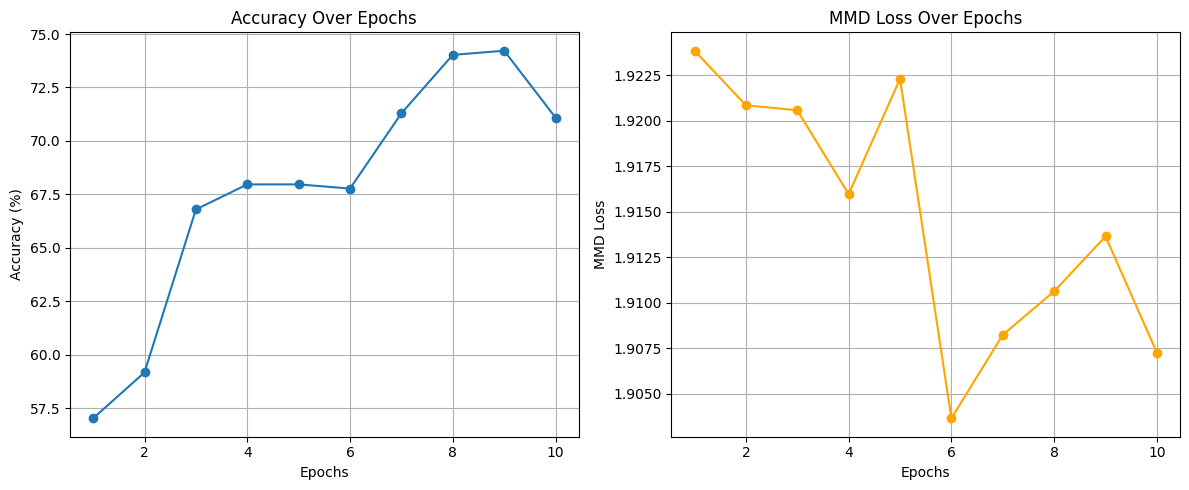

In [13]:
# Train the model
acc, loss = train_dan(model, source_loader, target_loader, optimizer, criterion, mmd_loss, epochs=10)
plot_metrics(10, acc, loss)

# A -> D

In [14]:
# Evaluate performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")

Source Accuracy: 76.78%
Target Accuracy: 68.88%
Performance Drop: 10.30%


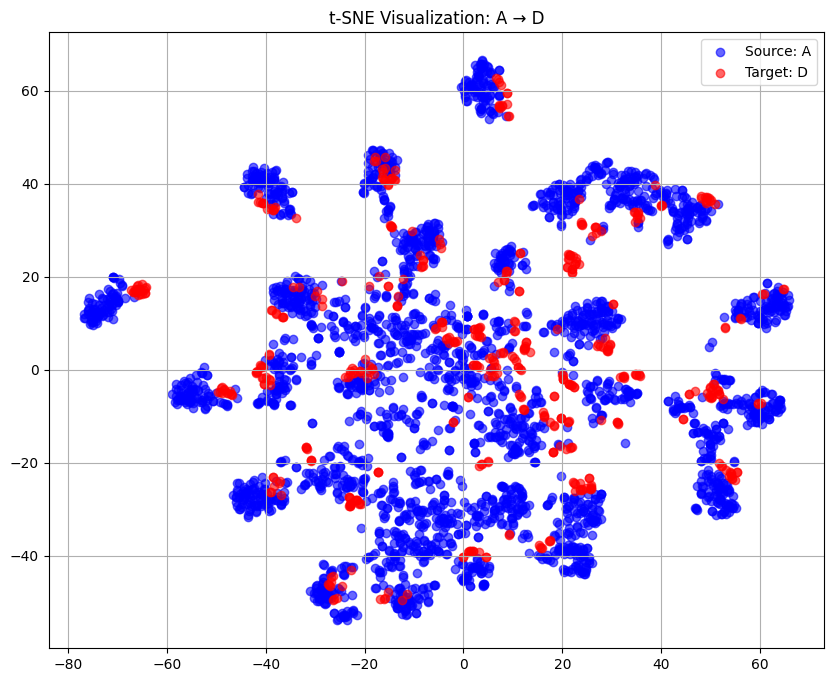

In [15]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='A',
    target_name='D'
)

# A -> W

In [16]:
source_path = '/kaggle/input/office31/Office-31/amazon'  # Path to source dataset
target_path = '/kaggle/input/office31/Office-31/webcam'    # Path to target dataset

source_loader, target_loader = create_loaders(source_path, target_path)

# Evaluate Performance
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100
# plot_tsne(source_features, target_features, source_labels, target_labels)

print(f"Source Amazon  Accuracy: {source_accuracy:.2f}%")
print(f"Target Webcam Accuracy: {target_accuracy:.2f}%")
print(f"Performance A -> W Drop: {drop:.2f}%")

Source Amazon  Accuracy: 77.14%
Target Webcam Accuracy: 67.42%
Performance A -> W Drop: 12.60%


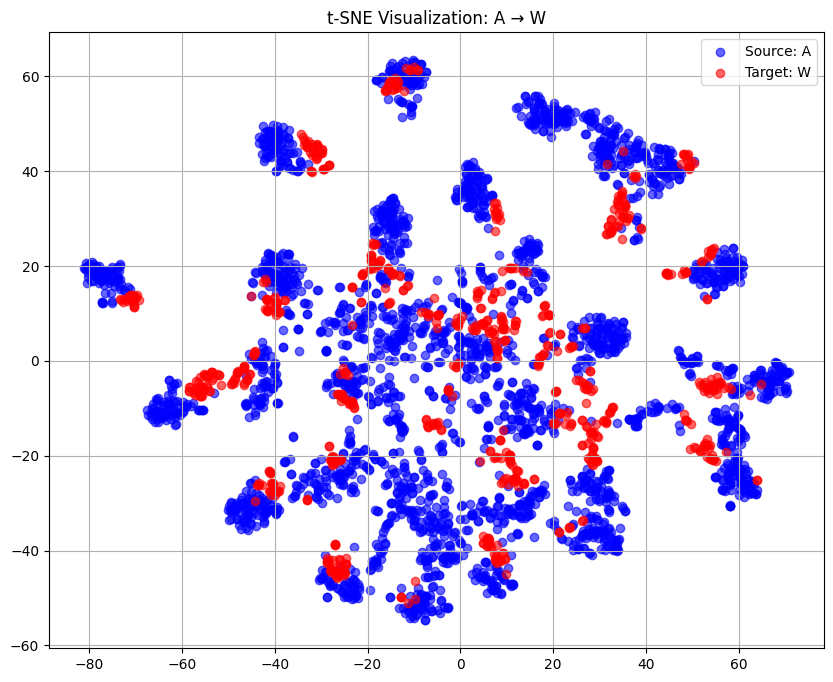

In [17]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='A',
    target_name='W'
)

# Source = DSLR

In [18]:
source_path = '/kaggle/input/office31/Office-31/dslr'  
target_path = '/kaggle/input/office31/Office-31/amazon'    
source_loader, target_loader = create_loaders(source_path, target_path)

num_classes = len(source_loader.dataset.classes)
# Model, Loss, and Optimizer
model = ResNetMMD(num_classes)
criterion = nn.CrossEntropyLoss()
mmd_loss = MMDLoss(kernel_num=5, kernel_mul=2.0, fix_gamma=False)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

model = fine_tune_on_source(model, source_loader, optimizer, criterion, epochs=10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 27.4086, Accuracy: 3.82%
Epoch [2/10], Loss: 27.3081, Accuracy: 5.42%
Epoch [3/10], Loss: 27.0607, Accuracy: 7.43%
Epoch [4/10], Loss: 26.8826, Accuracy: 8.84%
Epoch [5/10], Loss: 26.6559, Accuracy: 11.65%
Epoch [6/10], Loss: 26.4217, Accuracy: 13.45%
Epoch [7/10], Loss: 26.2051, Accuracy: 16.06%
Epoch [8/10], Loss: 26.0700, Accuracy: 16.67%
Epoch [9/10], Loss: 25.9273, Accuracy: 17.67%
Epoch [10/10], Loss: 25.6465, Accuracy: 18.88%


Epoch [1/10], Accuracy: 22.29%, Class Loss: 25.3993, MMD Loss: 1.9257, Total Loss: 29.2507
Epoch [2/10], Accuracy: 22.49%, Class Loss: 25.2641, MMD Loss: 1.9326, Total Loss: 29.1293
Epoch [3/10], Accuracy: 26.91%, Class Loss: 24.8390, MMD Loss: 1.9228, Total Loss: 28.6846
Epoch [4/10], Accuracy: 29.72%, Class Loss: 24.5780, MMD Loss: 1.9136, Total Loss: 28.4053
Epoch [5/10], Accuracy: 30.52%, Class Loss: 24.1600, MMD Loss: 1.9166, Total Loss: 27.9933
Epoch [6/10], Accuracy: 31.12%, Class Loss: 23.7571, MMD Loss: 1.9240, Total Loss: 27.6052
Epoch [7/10], Accuracy: 32.73%, Class Loss: 23.2503, MMD Loss: 1.9149, Total Loss: 27.0800
Epoch [8/10], Accuracy: 35.34%, Class Loss: 22.7025, MMD Loss: 1.9197, Total Loss: 26.5419
Epoch [9/10], Accuracy: 38.35%, Class Loss: 22.0352, MMD Loss: 1.9179, Total Loss: 25.8710
Epoch [10/10], Accuracy: 40.16%, Class Loss: 21.4810, MMD Loss: 1.9211, Total Loss: 25.3233


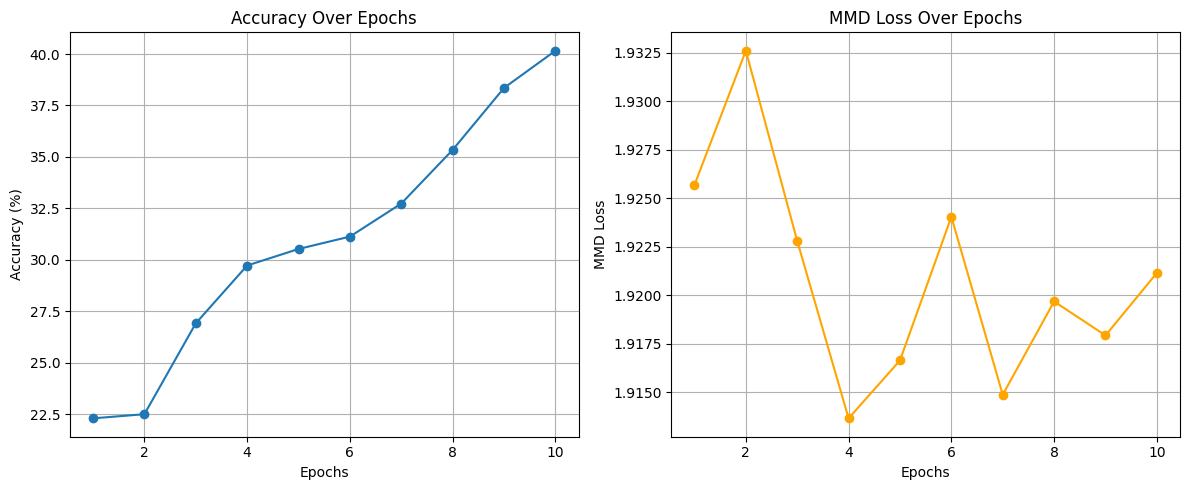

In [19]:
# Train the model
acc, loss = train_dan(model, source_loader, target_loader, optimizer, criterion, mmd_loss, epochs=10)
plot_metrics(10, acc, loss)

In [20]:
# Evaluate Performance
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source DSLR Accuracy: {source_accuracy:.2f}%")
print(f"Target Amazon Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop D -> A: {drop:.2f}%")

Source DSLR Accuracy: 45.78%
Target Amazon Accuracy: 19.10%
Performance Drop D -> A: 58.29%


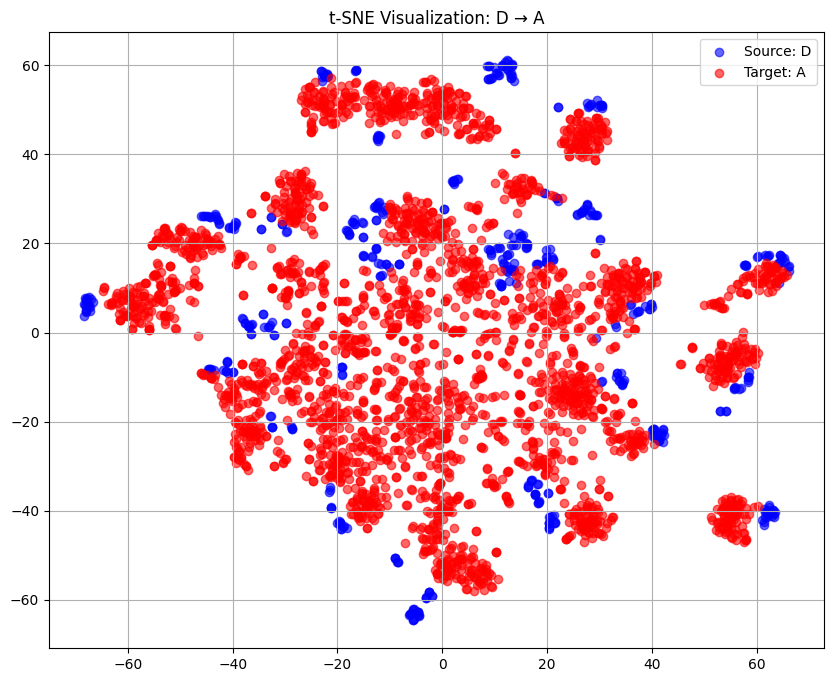

In [21]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='D',
    target_name='A'
)

In [22]:
target_path = '/kaggle/input/office31/Office-31/webcam'
source_loader, target_loader = create_loaders(source_path, target_path)

source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source DSLR Accuracy: {source_accuracy:.2f}%")
print(f"Target Webcam Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop D -> w: {drop:.2f}%")

Source DSLR Accuracy: 44.58%
Target Webcam Accuracy: 31.07%
Performance Drop D -> w: 30.30%


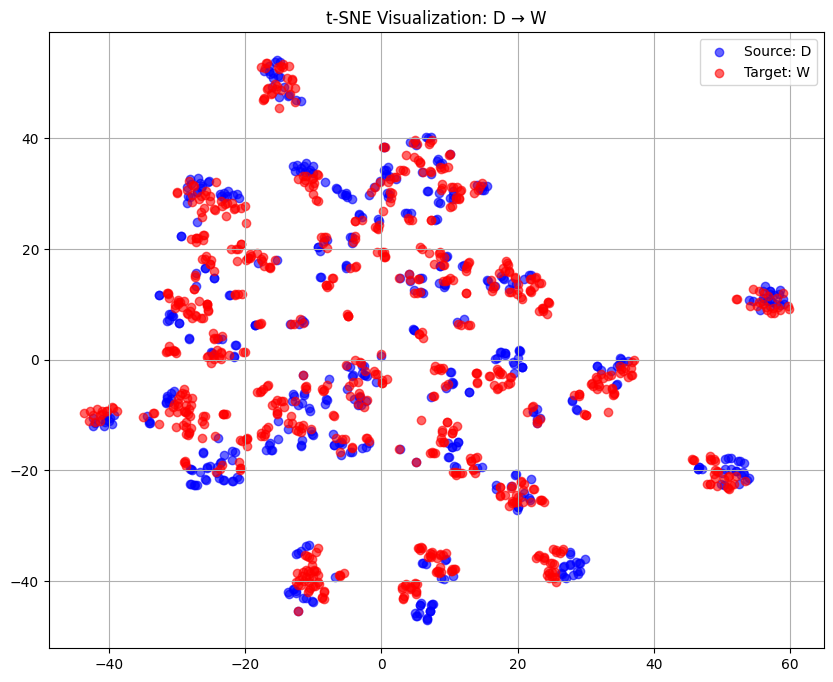

In [23]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='D',
    target_name='W'
)

# Source = Webcam

In [24]:
source_path = '/kaggle/input/office31/Office-31/webcam'  # Path to source dataset
target_path = '/kaggle/input/office31/Office-31/amazon'    # Path to target dataset

source_loader, target_loader = create_loaders(source_path, target_path)


num_classes = len(source_loader.dataset.classes)
# Model, Loss, and Optimizer
model = ResNetMMD(num_classes)
criterion = nn.CrossEntropyLoss()
mmd_loss = MMDLoss(kernel_num=5, kernel_mul=2.0, fix_gamma=False)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
model = fine_tune_on_source(model, source_loader, optimizer, criterion, epochs=10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 44.7124, Accuracy: 3.52%
Epoch [2/10], Loss: 44.2548, Accuracy: 5.91%
Epoch [3/10], Loss: 43.8925, Accuracy: 7.80%
Epoch [4/10], Loss: 43.3522, Accuracy: 9.43%
Epoch [5/10], Loss: 42.8728, Accuracy: 11.19%
Epoch [6/10], Loss: 42.6272, Accuracy: 11.45%
Epoch [7/10], Loss: 42.2958, Accuracy: 12.58%
Epoch [8/10], Loss: 41.9022, Accuracy: 16.10%
Epoch [9/10], Loss: 41.3496, Accuracy: 16.60%
Epoch [10/10], Loss: 40.8330, Accuracy: 21.64%


Epoch [1/10], Accuracy: 25.28%, Class Loss: 40.3594, MMD Loss: 3.2309, Total Loss: 46.8212
Epoch [2/10], Accuracy: 27.92%, Class Loss: 39.5682, MMD Loss: 3.2279, Total Loss: 46.0240
Epoch [3/10], Accuracy: 34.84%, Class Loss: 38.4204, MMD Loss: 3.2262, Total Loss: 44.8728
Epoch [4/10], Accuracy: 40.13%, Class Loss: 37.0796, MMD Loss: 3.2268, Total Loss: 43.5331
Epoch [5/10], Accuracy: 45.28%, Class Loss: 35.4610, MMD Loss: 3.2251, Total Loss: 41.9112
Epoch [6/10], Accuracy: 50.19%, Class Loss: 33.7871, MMD Loss: 3.2340, Total Loss: 40.2552
Epoch [7/10], Accuracy: 53.46%, Class Loss: 31.7986, MMD Loss: 3.2206, Total Loss: 38.2398
Epoch [8/10], Accuracy: 58.74%, Class Loss: 29.4631, MMD Loss: 3.2323, Total Loss: 35.9278
Epoch [9/10], Accuracy: 62.64%, Class Loss: 26.9238, MMD Loss: 3.2220, Total Loss: 33.3678
Epoch [10/10], Accuracy: 64.28%, Class Loss: 24.6609, MMD Loss: 3.2234, Total Loss: 31.1077


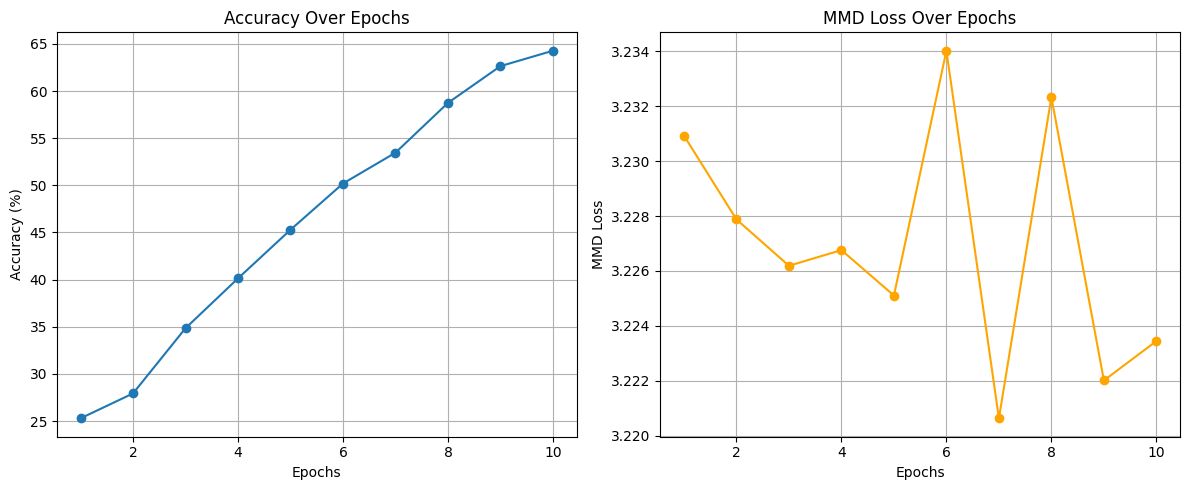

In [25]:
# Train the model
acc, loss = train_dan(model, source_loader, target_loader, optimizer, criterion, mmd_loss, epochs=10)
plot_metrics(10, acc, loss)

In [26]:
# Evaluate Performance
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Webcam Accuracy: {source_accuracy:.2f}%")
print(f"Target Amazon Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop W -> A: {drop:.2f}%")

Source Webcam Accuracy: 67.04%
Target Amazon Accuracy: 44.55%
Performance Drop W -> A: 33.55%


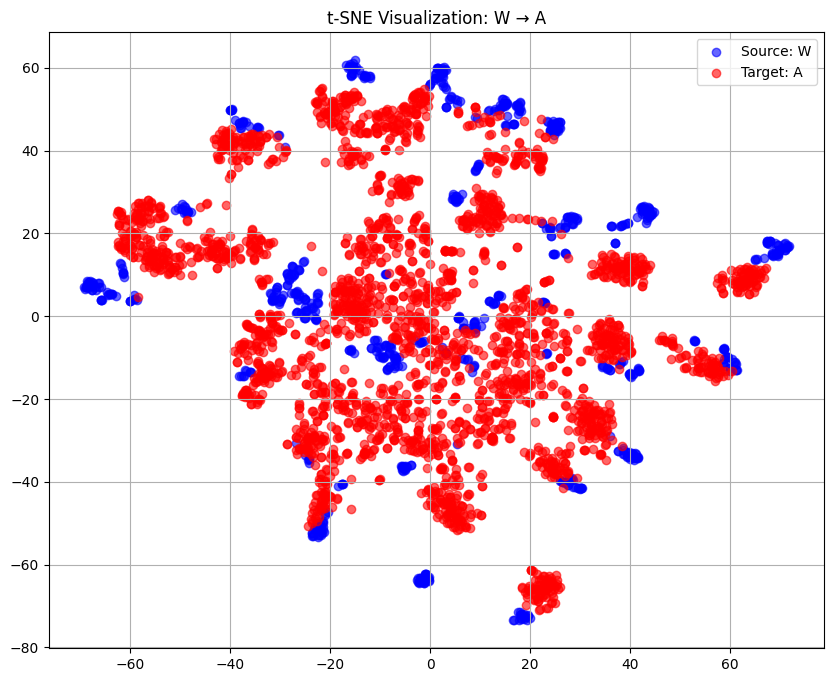

In [27]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='W',
    target_name='A'
)

In [28]:
target_path = '/kaggle/input/office31/Office-31/dslr'
source_loader, target_loader = create_loaders(source_path, target_path)
# Extract Features

# Evaluate Performance
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Webcam Accuracy: {source_accuracy:.2f}%")
print(f"Target DSLR Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop W -> D: {drop:.2f}%")

Source Webcam Accuracy: 68.55%
Target DSLR Accuracy: 57.23%
Performance Drop W -> D: 16.52%


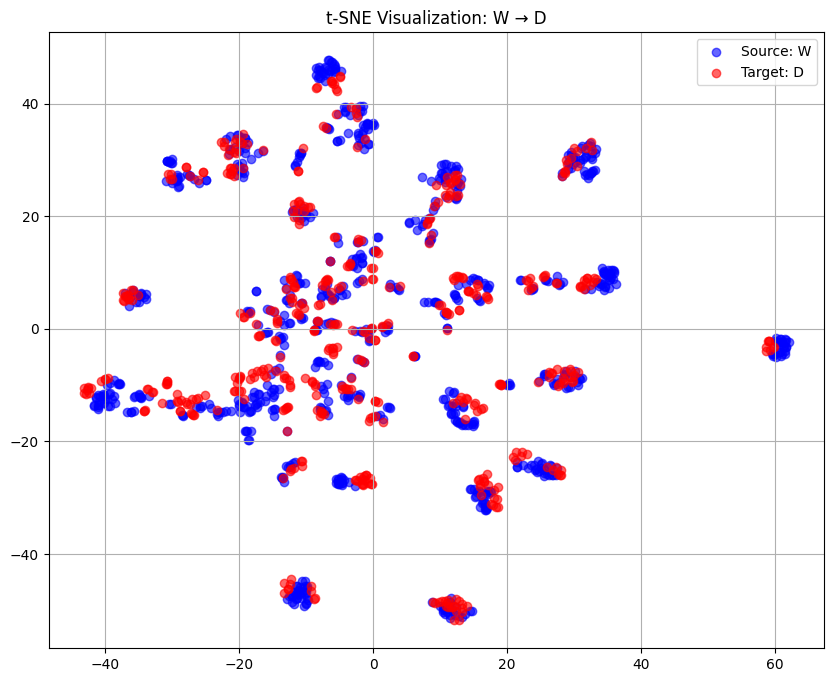

In [29]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='W',
    target_name='D'
)

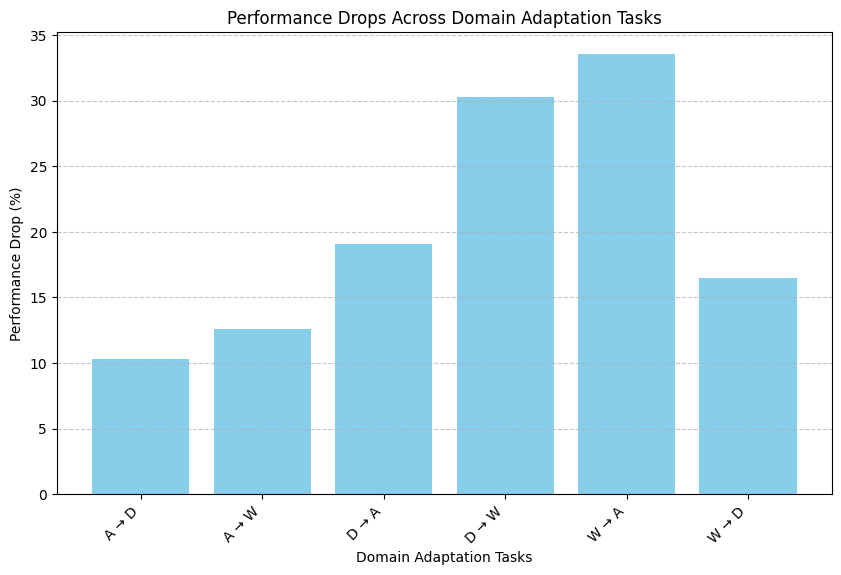

In [55]:
import matplotlib.pyplot as plt

# Define the tasks and their corresponding performance drops
tasks = [
    "A → D",
    "A → W",
    "D → A",
    "D → W",
    "W → A",
    "W → D"
]
performance_drops = [10.3, 12.6, 19.1, 30.30, 33.55, 16.5]

# Plot the performance drops
plt.figure(figsize=(10, 6))
plt.bar(tasks, performance_drops, color='skyblue')
plt.title("Performance Drops Across Domain Adaptation Tasks")
plt.xlabel("Domain Adaptation Tasks")
plt.ylabel("Performance Drop (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Digits Dataset

In [31]:
from torch.utils.data import Subset
import random

def load_digits_dataset(source_domain, target_domain, batch_size=32, subset_size=1000):
    """Loads custom digits datasets (MNIST, USPS, SVHN) for source and target domains with optional subset."""
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for 3 channels
        ]),
        'val': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for 3 channels
        ])
    }

    dataset_mapping = {
        'MNIST': lambda train: datasets.MNIST(root="./data", train=train, download=True, transform=data_transforms['train' if train else 'val']),
        'USPS': lambda train: datasets.USPS(root="./data", train=train, download=True, transform=data_transforms['train' if train else 'val']),
        'SVHN': lambda train: datasets.SVHN(root="./data", split='train' if train else 'test', download=True, transform=data_transforms['train' if train else 'val'])
    }

    if source_domain not in dataset_mapping or target_domain not in dataset_mapping:
        raise ValueError("Invalid domain. Supported domains are: MNIST, USPS, SVHN")

    source_dataset = dataset_mapping[source_domain](train=True)
    target_dataset = dataset_mapping[target_domain](train=False)

    # Apply subset if specified
    if subset_size:
        source_indices = random.sample(range(len(source_dataset)), subset_size)
        target_indices = random.sample(range(len(target_dataset)), subset_size)
        source_dataset = Subset(source_dataset, source_indices)
        target_dataset = Subset(target_dataset, target_indices)

    source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return source_loader, target_loader

# M -> U

In [32]:
from torchvision import datasets

In [34]:
source_loader, target_loader = load_digits_dataset('MNIST', 'USPS', batch_size=32)

# Initialize model, loss, and optimizer
num_classes = 10
# Model, Loss, and Optimizer
model = ResNetMMD(num_classes)
criterion = nn.CrossEntropyLoss()
mmd_loss = MMDLoss(kernel_num=5, kernel_mul=2.0, fix_gamma=False)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

model = fine_tune_on_source(model, source_loader, optimizer, criterion, epochs=10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 73.7601, Accuracy: 11.90%
Epoch [2/10], Loss: 72.2201, Accuracy: 16.10%
Epoch [3/10], Loss: 70.8389, Accuracy: 25.40%
Epoch [4/10], Loss: 69.4425, Accuracy: 30.60%
Epoch [5/10], Loss: 67.8785, Accuracy: 35.80%
Epoch [6/10], Loss: 65.5460, Accuracy: 38.60%
Epoch [7/10], Loss: 63.4320, Accuracy: 43.00%
Epoch [8/10], Loss: 60.3159, Accuracy: 45.20%
Epoch [9/10], Loss: 57.4946, Accuracy: 51.60%
Epoch [10/10], Loss: 55.3288, Accuracy: 51.50%


Epoch [1/10], Accuracy: 57.40%, Class Loss: 46.1876, MMD Loss: 16.4092, Total Loss: 79.0059
Epoch [2/10], Accuracy: 85.00%, Class Loss: 22.3047, MMD Loss: 16.2971, Total Loss: 54.8990
Epoch [3/10], Accuracy: 93.10%, Class Loss: 10.5908, MMD Loss: 16.2136, Total Loss: 43.0180
Epoch [4/10], Accuracy: 95.40%, Class Loss: 6.7636, MMD Loss: 16.2009, Total Loss: 39.1653
Epoch [5/10], Accuracy: 97.10%, Class Loss: 4.3801, MMD Loss: 16.1830, Total Loss: 36.7461
Epoch [6/10], Accuracy: 97.40%, Class Loss: 4.0236, MMD Loss: 16.1300, Total Loss: 36.2835
Epoch [7/10], Accuracy: 95.50%, Class Loss: 6.7271, MMD Loss: 16.1176, Total Loss: 38.9623
Epoch [8/10], Accuracy: 95.50%, Class Loss: 6.4254, MMD Loss: 16.1127, Total Loss: 38.6507
Epoch [9/10], Accuracy: 96.10%, Class Loss: 5.4914, MMD Loss: 16.1184, Total Loss: 37.7282
Epoch [10/10], Accuracy: 96.10%, Class Loss: 4.2472, MMD Loss: 16.1380, Total Loss: 36.5233


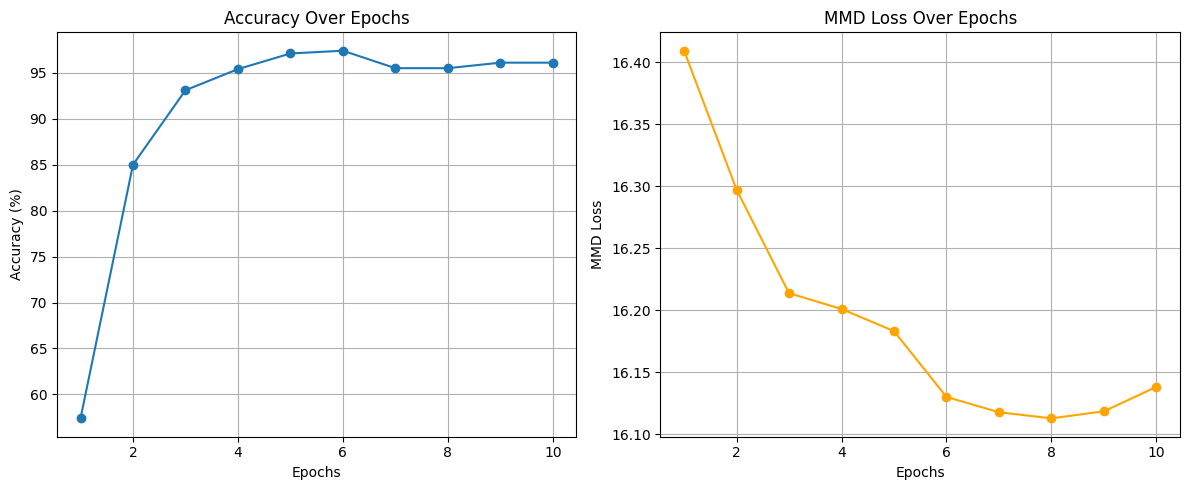

In [35]:
# Train the model
acc, loss = train_dan(model, source_loader, target_loader, optimizer, criterion, mmd_loss, epochs=10)
plot_metrics(10, acc, loss)

In [36]:
# Evaluate Performance
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source MNIST Accuracy: {source_accuracy:.2f}%")
print(f"Target USPS Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop M -> U: {drop:.2f}%")

Source MNIST Accuracy: 95.30%
Target USPS Accuracy: 72.80%
Performance Drop M -> U: 23.61%


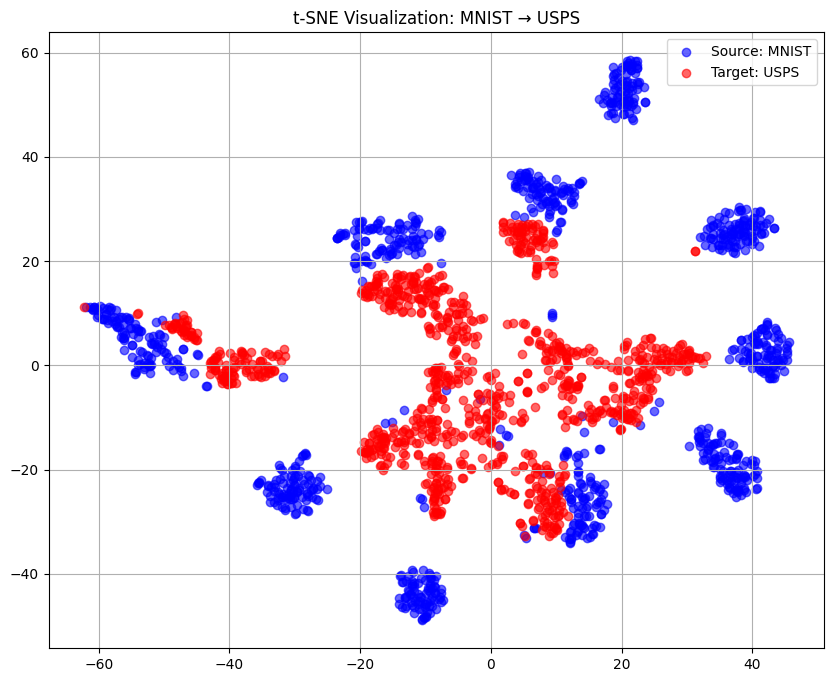

In [37]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='MNIST',
    target_name='USPS'
)

In [53]:
source_loader, target_loader = load_digits_dataset('MNIST', 'SVHN', batch_size=32)

source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source MNIST Accuracy: {source_accuracy:.2f}%")
print(f"Target SVHN Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop M -> S: {drop:.2f}%")

Using downloaded and verified file: ./data/test_32x32.mat
Source MNIST Accuracy: 70.80%
Target SVHN Accuracy: 52.00%
Performance Drop M -> S: 26.55%


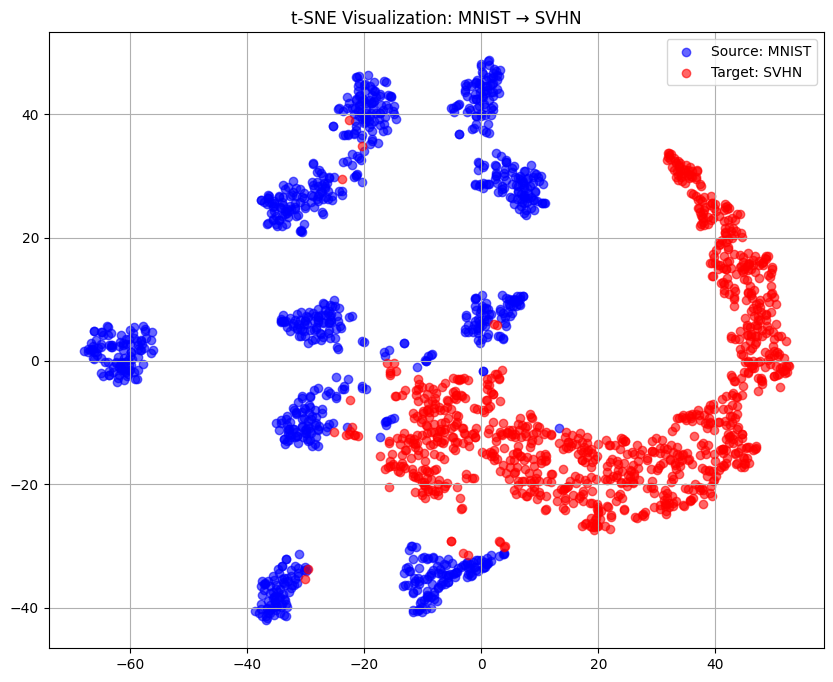

In [39]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='MNIST',
    target_name='SVHN'
)

In [40]:
source_loader, target_loader = load_digits_dataset('SVHN', 'MNIST', batch_size=32)

# Initialize model, loss, and optimizer
# num_classes = len(source_loader.dataset.classesabs)
num_classes = 10
# Model, Loss, and Optimizer
model = ResNetMMD(num_classes)
criterion = nn.CrossEntropyLoss()
mmd_loss = MMDLoss(kernel_num=5, kernel_mul=2.0, fix_gamma=False)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

model = fine_tune_on_source(model, source_loader, optimizer, criterion, epochs=10)

100%|██████████| 182040794/182040794 [00:40<00:00, 4458326.96it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 72.2812, Accuracy: 18.30%
Epoch [2/10], Loss: 71.0322, Accuracy: 21.80%
Epoch [3/10], Loss: 70.6364, Accuracy: 21.80%
Epoch [4/10], Loss: 70.4059, Accuracy: 21.50%
Epoch [5/10], Loss: 70.1320, Accuracy: 20.30%
Epoch [6/10], Loss: 68.9808, Accuracy: 24.50%
Epoch [7/10], Loss: 68.9838, Accuracy: 24.10%
Epoch [8/10], Loss: 68.5213, Accuracy: 23.80%
Epoch [9/10], Loss: 68.1551, Accuracy: 26.30%
Epoch [10/10], Loss: 68.0793, Accuracy: 24.40%


Epoch [1/10], Accuracy: 27.90%, Class Loss: 66.7435, MMD Loss: 16.3914, Total Loss: 99.5263
Epoch [2/10], Accuracy: 30.60%, Class Loss: 62.8562, MMD Loss: 16.3702, Total Loss: 95.5965
Epoch [3/10], Accuracy: 37.20%, Class Loss: 57.5765, MMD Loss: 16.3871, Total Loss: 90.3506
Epoch [4/10], Accuracy: 45.50%, Class Loss: 52.2604, MMD Loss: 16.3413, Total Loss: 84.9430
Epoch [5/10], Accuracy: 50.90%, Class Loss: 46.1345, MMD Loss: 16.2845, Total Loss: 78.7035
Epoch [6/10], Accuracy: 56.50%, Class Loss: 39.4334, MMD Loss: 16.2143, Total Loss: 71.8620
Epoch [7/10], Accuracy: 64.10%, Class Loss: 34.4648, MMD Loss: 16.1554, Total Loss: 66.7757
Epoch [8/10], Accuracy: 66.00%, Class Loss: 33.2042, MMD Loss: 16.0829, Total Loss: 65.3701
Epoch [9/10], Accuracy: 72.50%, Class Loss: 27.6066, MMD Loss: 16.1045, Total Loss: 59.8156
Epoch [10/10], Accuracy: 75.80%, Class Loss: 23.9065, MMD Loss: 16.1121, Total Loss: 56.1307


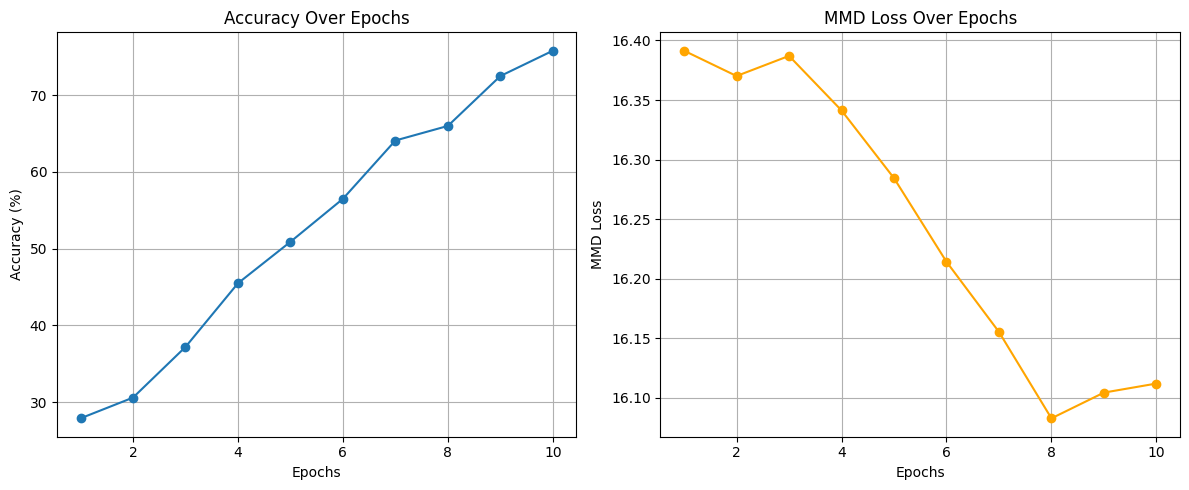

In [41]:
# Train the model
acc, loss = train_dan(model, source_loader, target_loader, optimizer, criterion, mmd_loss, epochs=10)
plot_metrics(10, acc, loss)

In [42]:
# Evaluate Performance
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source SVHN Accuracy: {source_accuracy:.2f}%")
print(f"Target MNIST Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop S -> M: {drop:.2f}%")

Source SVHN Accuracy: 43.70%
Target MNIST Accuracy: 43.80%
Performance Drop S -> M: -0.23%


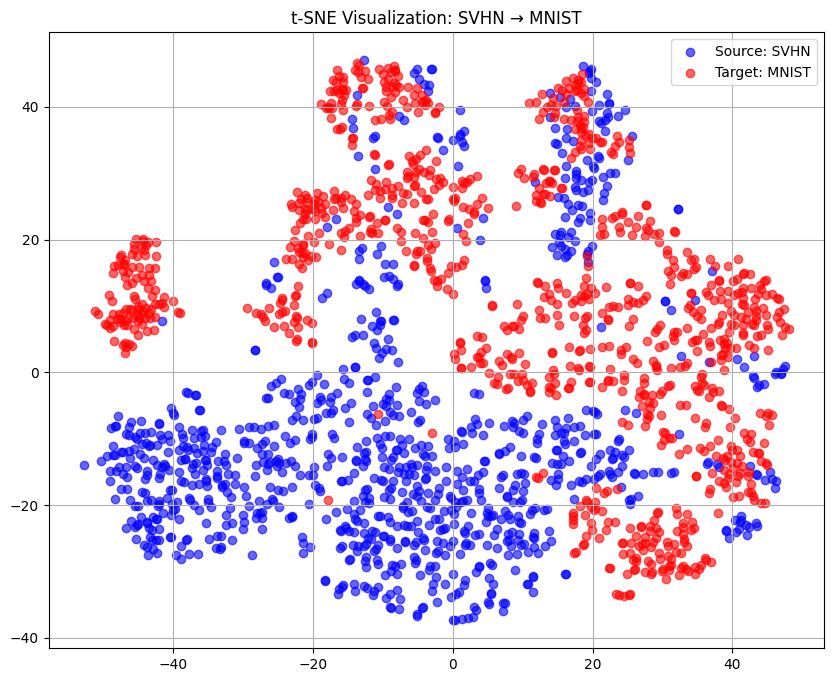

In [43]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='SVHN',
    target_name='MNIST'
)

In [44]:
source_loader, target_loader = load_digits_dataset('SVHN', 'USPS', batch_size=32)

source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source SVHN Accuracy: {source_accuracy:.2f}%")
print(f"Target USPS Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop S -> U: {drop:.2f}%")

Using downloaded and verified file: ./data/train_32x32.mat
Source SVHN Accuracy: 34.10%
Target USPS Accuracy: 33.70%
Performance Drop S -> U: 1.17%


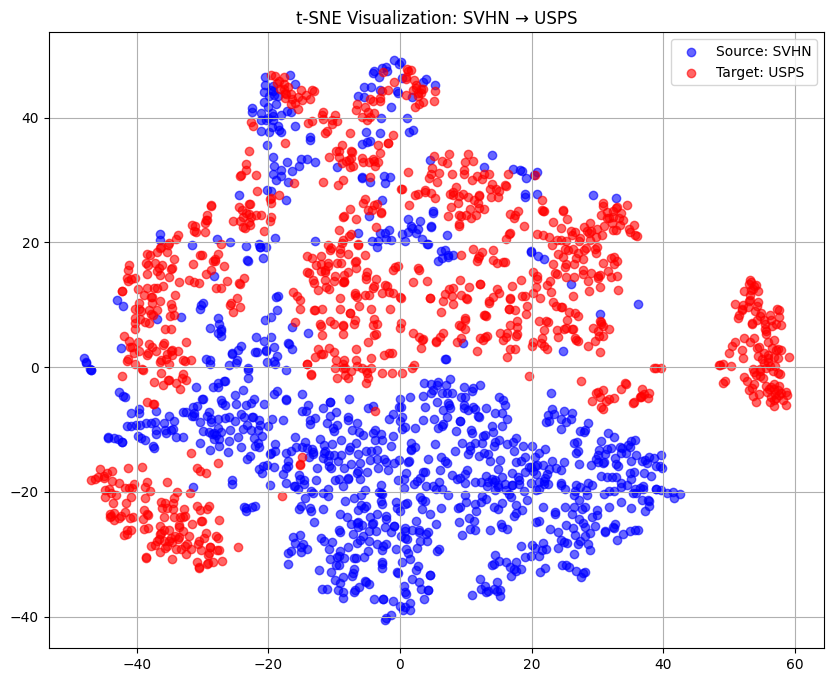

In [45]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='SVHN',
    target_name='USPS'
)

In [46]:
source_loader, target_loader = load_digits_dataset('USPS', 'MNIST', batch_size=32)

# Initialize model, loss, and optimizer
# num_classes = len(source_loader.dataset.classesabs)
num_classes = 10
# Model, Loss, and Optimizer
model = ResNetMMD(num_classes)
criterion = nn.CrossEntropyLoss()
mmd_loss = MMDLoss(kernel_num=5, kernel_mul=2.0, fix_gamma=False)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

model = fine_tune_on_source(model, source_loader, optimizer, criterion, epochs=10)

100%|██████████| 6579383/6579383 [00:08<00:00, 772252.41it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 72.5133, Accuracy: 14.70%
Epoch [2/10], Loss: 70.8551, Accuracy: 21.20%
Epoch [3/10], Loss: 68.4160, Accuracy: 29.20%
Epoch [4/10], Loss: 65.9813, Accuracy: 30.80%
Epoch [5/10], Loss: 63.2010, Accuracy: 40.20%
Epoch [6/10], Loss: 59.7698, Accuracy: 46.90%
Epoch [7/10], Loss: 56.0192, Accuracy: 48.50%
Epoch [8/10], Loss: 52.4773, Accuracy: 50.80%
Epoch [9/10], Loss: 50.5260, Accuracy: 55.10%
Epoch [10/10], Loss: 45.9639, Accuracy: 57.30%


Epoch [1/10], Accuracy: 62.80%, Class Loss: 39.4569, MMD Loss: 16.4176, Total Loss: 72.2921
Epoch [2/10], Accuracy: 84.80%, Class Loss: 19.2335, MMD Loss: 16.3042, Total Loss: 51.8419
Epoch [3/10], Accuracy: 91.30%, Class Loss: 11.0385, MMD Loss: 16.2585, Total Loss: 43.5556
Epoch [4/10], Accuracy: 93.30%, Class Loss: 7.7735, MMD Loss: 16.2270, Total Loss: 40.2274
Epoch [5/10], Accuracy: 95.40%, Class Loss: 6.1567, MMD Loss: 16.1987, Total Loss: 38.5541
Epoch [6/10], Accuracy: 96.60%, Class Loss: 4.5191, MMD Loss: 16.2113, Total Loss: 36.9416
Epoch [7/10], Accuracy: 98.00%, Class Loss: 3.3007, MMD Loss: 16.1703, Total Loss: 35.6413
Epoch [8/10], Accuracy: 97.90%, Class Loss: 2.7395, MMD Loss: 16.1661, Total Loss: 35.0717
Epoch [9/10], Accuracy: 98.50%, Class Loss: 2.9152, MMD Loss: 16.1499, Total Loss: 35.2150
Epoch [10/10], Accuracy: 98.70%, Class Loss: 3.0135, MMD Loss: 16.1315, Total Loss: 35.2765


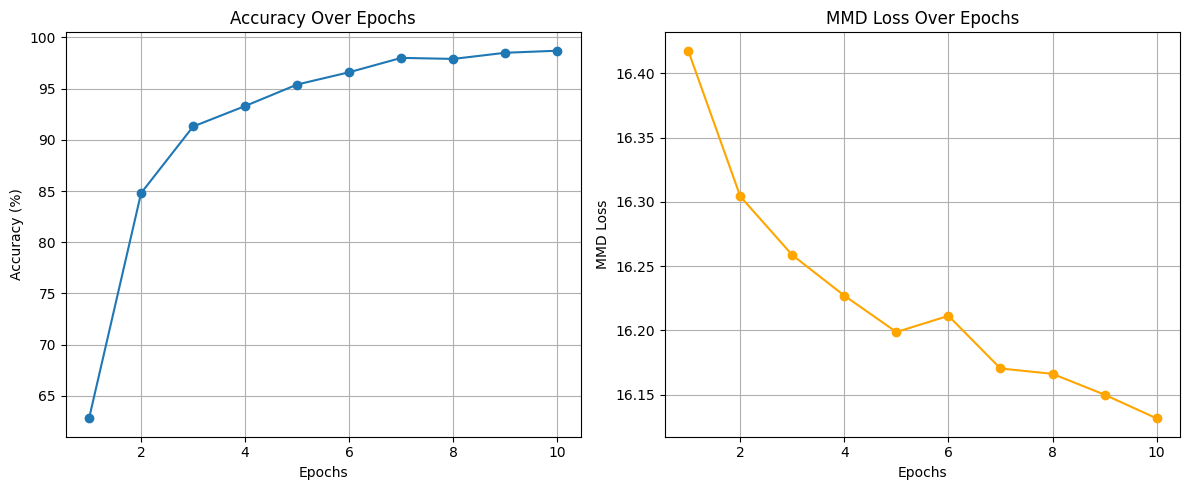

In [47]:
# Train the model
acc, loss = train_dan(model, source_loader, target_loader, optimizer, criterion, mmd_loss, epochs=10)
plot_metrics(10, acc, loss)

In [48]:
# Evaluate Performance
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source USPS Accuracy: {source_accuracy:.2f}%")
print(f"Target MNIST Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop U -> M: {drop:.2f}%")

Source USPS Accuracy: 93.40%
Target MNIST Accuracy: 72.20%
Performance Drop U -> M: 22.70%


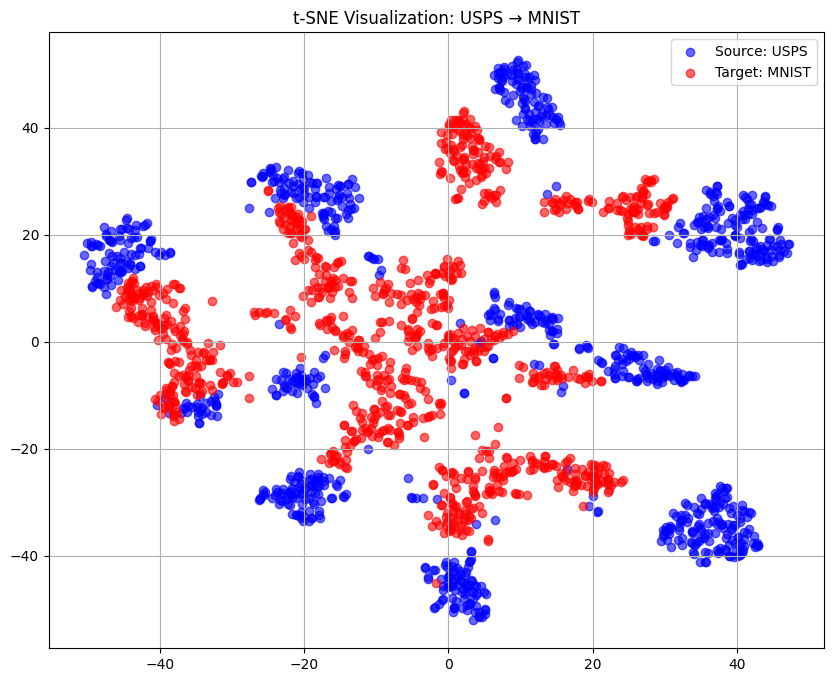

In [49]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='USPS',
    target_name='MNIST'
)

In [52]:
source_loader, target_loader = load_digits_dataset('USPS', 'SVHN', batch_size=32)

source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source USPS Accuracy: {source_accuracy:.2f}%")
print(f"Target SVHN Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop U -> S: {drop:.2f}%")

Using downloaded and verified file: ./data/test_32x32.mat
Source USPS Accuracy: 93.10%
Target SVHN Accuracy: 65.31%
Performance Drop U -> S: 29.85%


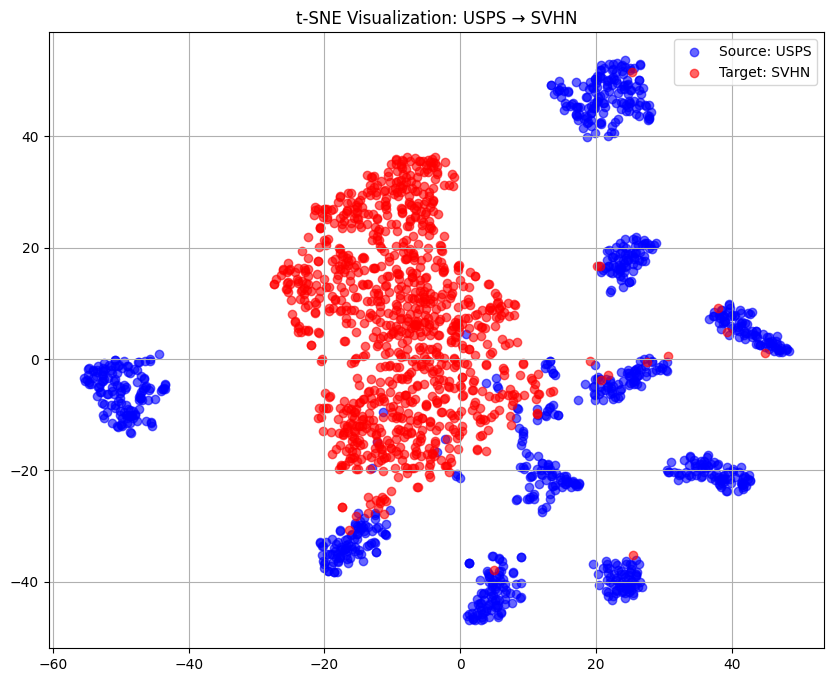

In [51]:
visualize_tsne(
    source_loader=source_loader,
    target_loader=target_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    source_name='USPS',
    target_name='SVHN'
)

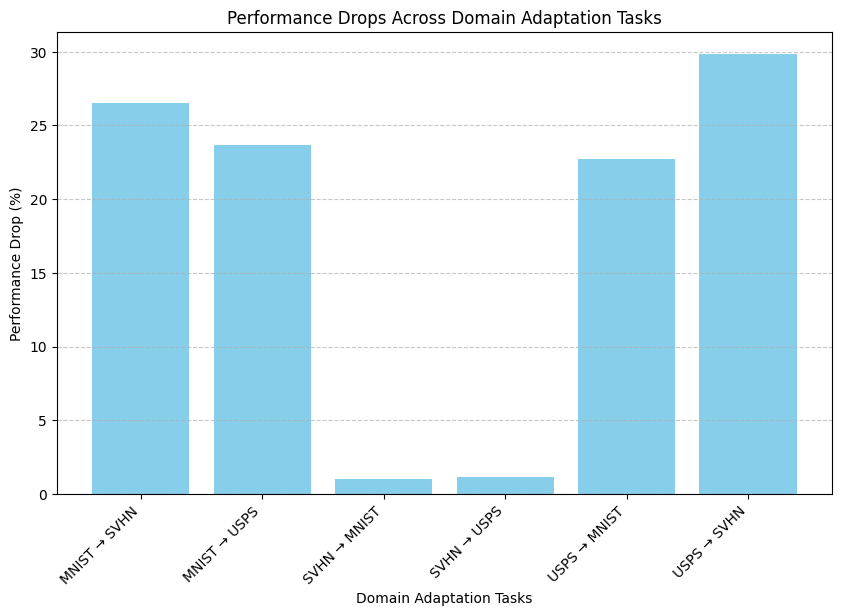

In [54]:
import matplotlib.pyplot as plt

# Define the tasks and their corresponding performance drops
tasks = [
    "MNIST → SVHN",
    "MNIST → USPS",
    "SVHN → MNIST",
    "SVHN → USPS",
    "USPS → MNIST",
    "USPS → SVHN"
]
performance_drops = [26.55, 23.66, 1, 1.17, 22.70, 29.85]

# Plot the performance drops
plt.figure(figsize=(10, 6))
plt.bar(tasks, performance_drops, color='skyblue')
plt.title("Performance Drops Across Domain Adaptation Tasks")
plt.xlabel("Domain Adaptation Tasks")
plt.ylabel("Performance Drop (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# WE ARE DONE